# Exploratory Data Analysis

Goal:
- Determine max_len for questions (max number of tokens in questions)
- Determine max_words for questions (vocab size for questions)
- Determine k for answers (number of unique answers)
- Determine closed vs open answers distribution
- Inspecting some of the data samples (images, questions, answers)

To avoid test-set leakage, all preprocessing decisions (questions length cutoff, word vocabulary, and top-k answer set) are derived only from the training split.

## 1. Setup & Import

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from woa7015_medvqa.v2.data.slake import SLAKEDataset
from woa7015_medvqa.v2.data.tokenizers import (
    build_answer_vocab,
    build_question_vocab,
    make_answer_encoder,
    make_question_encoder,
    normalize_text,
)
from woa7015_medvqa.v2.utils import display_examples


In [2]:
PROJECT_ROOT = Path.cwd().parent
DATASET_DIR = PROJECT_ROOT / "data" / "SLAKE"

train_ds = SLAKEDataset(root_dir=DATASET_DIR, split="train")

## 2. Determine max_len for questions

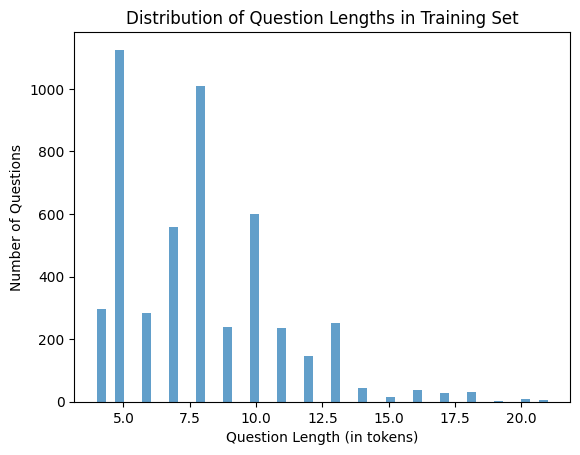

Max question length in training set: 21


In [3]:
train_q_len = [len(normalize_text(x["question"]).split()) for x in train_ds]

plt.hist(
    train_q_len,
    bins=50,
    alpha=0.7,
)
plt.xlabel("Question Length (in tokens)")
plt.ylabel("Number of Questions")
plt.title("Distribution of Question Lengths in Training Set")
plt.show()

max_train_q_len = max(train_q_len)
print(f"Max question length in training set: {max_train_q_len}")

> Verdict: max question length is 21 tokens, set max_len = 32 (to have some buffer)
> - protect against any slightly longer questions in val/test sets
> - virtually no effect on computational cost, we're just padding to the next power of 2

## 3. Determine max_words for questions

In [4]:
train_q_vocab = set(
    token for x in train_ds for token in normalize_text(x["question"]).split()
)

print(f"Training question vocabulary size: {len(train_q_vocab)}")


Training question vocabulary size: 290


> Verdict: training question vocab size is 290, set max_words = 290
> - <pad> and <unk> tokens will be used if new words are found in val/test sets, no point in increasing vocab size further
> - we'll have 292 tokens in total (including <pad> and <unk>)

## 4. Determine k for answers

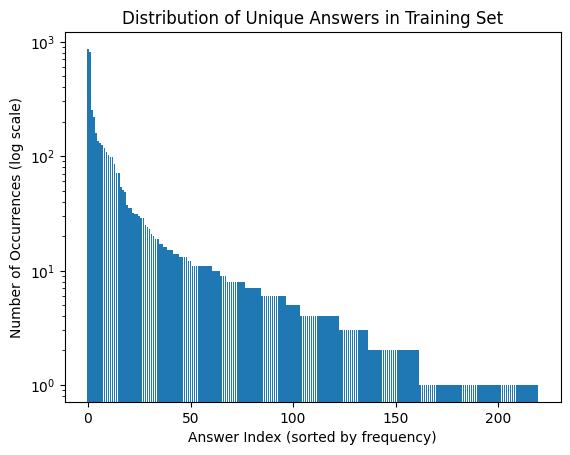

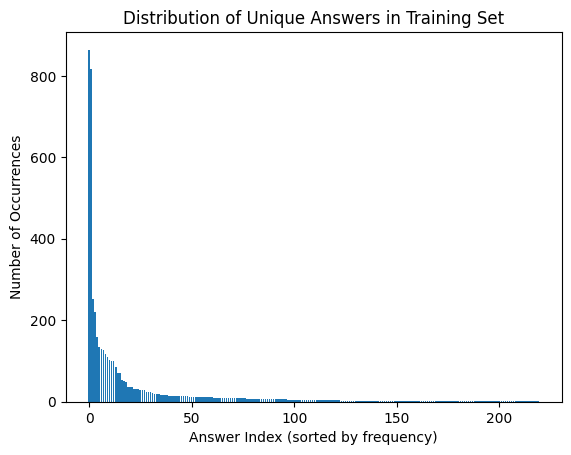

Number of unique answers: 220


In [5]:
df_answers = pd.DataFrame(train_ds.samples, columns=["answer", "answer_type"])
df_answers["answer"] = df_answers["answer"].apply(lambda x: normalize_text(x))

df_answers_unique_count = df_answers["answer"].value_counts().reset_index()

# Log scale plot of unique answers
plt.bar(range(len(df_answers_unique_count)), df_answers_unique_count["count"])
plt.yscale("log")
plt.xlabel("Answer Index (sorted by frequency)")
plt.ylabel("Number of Occurrences (log scale)")
plt.title("Distribution of Unique Answers in Training Set")
plt.show()

# Non-log scale printout of number of unique answers
plt.bar(range(len(df_answers_unique_count)), df_answers_unique_count["count"])
plt.xlabel("Answer Index (sorted by frequency)")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Unique Answers in Training Set")
plt.show()


print(f"Number of unique answers: {len(df_answers_unique_count)}")


In [6]:
df_answers_unique_count

,answer,count
0,yes,864
1,no,817
2,lung,253
3,chest,220
4,liver,159
...,...,...
215,small bowel colon rectum,1
216,lower middle,1
217,liver heart spleen,1
218,liver heart lung,1


In [7]:
# analyze the percentiles, see where most answers lie
percentiles = [50, 75, 90, 95, 99, 100]
percentile_values = np.percentile(df_answers_unique_count["count"], percentiles)
for p, val in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {val:.2f} occurrences")

50th percentile: 4.00 occurrences
75th percentile: 11.00 occurrences
90th percentile: 32.30 occurrences
95th percentile: 99.20 occurrences
99th percentile: 246.73 occurrences
100th percentile: 864.00 occurrences


Closed answers: 1943 (39.50%)
Open answers: 2976 (60.50%)
Number of unique closed answers: 33
Number of unique open answers: 216


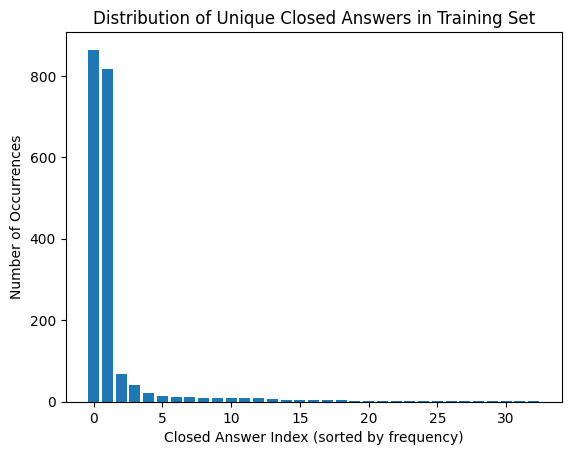

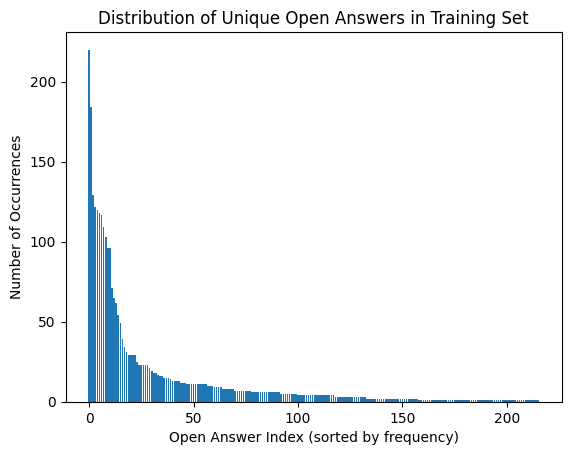

In [8]:
df_answers_closed = df_answers[df_answers["answer_type"] == "CLOSED"]
df_answers_open = df_answers[df_answers["answer_type"] == "OPEN"]
print(
    f"Closed answers: {len(df_answers_closed)} ({len(df_answers_closed) / len(df_answers) * 100:.2f}%)"
)
print(
    f"Open answers: {len(df_answers_open)} ({len(df_answers_open) / len(df_answers) * 100:.2f}%)"
)
print(f"Number of unique closed answers: {df_answers_closed['answer'].nunique()}")
print(f"Number of unique open answers: {df_answers_open['answer'].nunique()}")

# Unique closed answers
df_answers_closed_unique_count = (
    df_answers_closed["answer"].value_counts().reset_index()
)

# Unique open answers
df_answers_open_unique_count = df_answers_open["answer"].value_counts().reset_index()

# Plot unique closed answers
plt.bar(
    range(len(df_answers_closed_unique_count)),
    df_answers_closed_unique_count["count"],
)
plt.xlabel("Closed Answer Index (sorted by frequency)")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Unique Closed Answers in Training Set")
plt.show()

# Plot unique open answers
plt.bar(
    range(len(df_answers_open_unique_count)),
    df_answers_open_unique_count["count"],
)
plt.xlabel("Open Answer Index (sorted by frequency)")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Unique Open Answers in Training Set")
plt.show()

In [9]:
df_answers_closed_unique_count

,answer,count
0,yes,864
1,no,817
2,lung,69
3,liver,41
4,heart,21
5,transverse plane,13
6,left,12
7,right,12
8,kidney,10
9,t2,9


In [10]:
df_answers_open_unique_count

,answer,count
0,chest,220
1,lung,184
2,head,129
3,transverse plane,122
4,ct,120
...,...,...
211,small bowel colon rectum,1
212,lower middle,1
213,liver heart spleen,1
214,liver heart lung,1


> Verdict: set k = 220, exactly the number of unique answers in training set
> - although the freq distribution is long-tailed, 220 is not huge
> - <unk> will be used for any new answers in val/test sets
> - closed vs open answers distribution are also long-tailed

## 5. Inspecting some of the data samples (images, questions, answers)

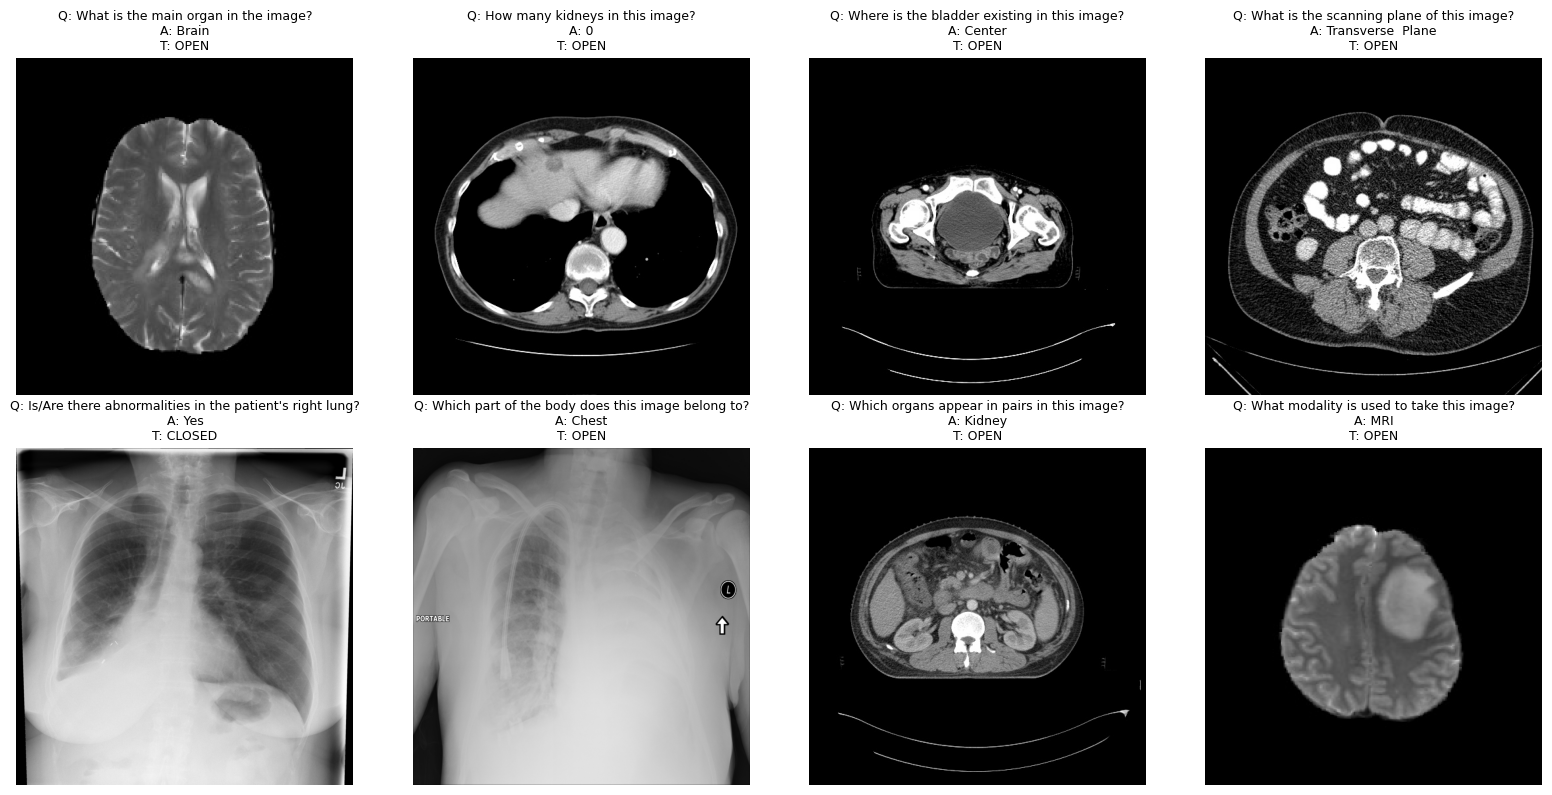

In [11]:
random_indices = np.random.choice(len(train_ds), size=8, replace=False)
display_examples([train_ds[i] for i in random_indices], n=8, cols=4, figsize=(16, 8))

## 6. Finalize preprocessing parameters

In [12]:
MAX_Q_LEN = 32
MAX_Q_WORDS = 290
K = 220


In [13]:
a_vocab, a2id, id2a = build_answer_vocab(
    DATASET_DIR / "train.json",
    topk=K,
)
encode_a = make_answer_encoder(a2id)

q_vocab, q2id = build_question_vocab(
    DATASET_DIR / "train.json",
    max_words=MAX_Q_WORDS,
)
encode_q = make_question_encoder(q2id, max_len=MAX_Q_LEN)

In [14]:
print(f"{len(a_vocab)=}, {a_vocab=}")
print(f"{len(a2id)=}, {a2id=}")
print(f"{len(q_vocab)=}, {q_vocab=}")
print(f"{len(q2id)=}, {q2id=}")

len(a_vocab)=221, a_vocab=['yes', 'no', 'lung', 'chest', 'liver', 'transverse plane', 'head', 'ct', 'brain', '2', 'abdomen', 'mri', 'xray', 'heart', 't2', 'black', 'breathe', 'left', '0', 't1', 'right', 'right lung', 'coronal plane', 'center', 'spleen', 'left lung', 'none', '1', 'pelvic cavity', 'gray', 'lower left lung', 'liver cancer', 'white', 'spinal cord', 'left lung right', 'upper left', 'small bowel', 'top', '3', 'cardiomegaly', 'irregular', 'brain edema brain enhancing tumor brain nonenhancing tumor', 'kidney', 'stomach', 'promote blood flow', 'right lung left', 'circular', 'brain tumor brain edema', 'bladder', 'lung cancer', 'pay attention to dietary hygiene strengthen physical fitness and avoid brain trauma', 'lung heart', 'atelectasis', 'pneumonia', 'medical treatment surgical treatment', 'a little', 'lower right lung', 'much', 'visual impairment vomiting tinnitus increased intracranial pressure', 'medical treatment supportive treatment surgical treatment', 'left lobe', 'nod